# Rapport Projet :

## Présentation du projet : 
Nous sommes trois sportifs et nous avions à cœur de lier notre projet de programmation avec le monde du sport. 
Pour explorer tous les enseignements du cours, nous avons cherché un sport dans lequel la prédiction statistique 
aurait pu répondre à des questions pratiques pour les joueurs et les entraîneurs. 
Comme deux d'entre nous pratiquent le handball, nous nous sommes donnés comme objectif d'élaborer un modèle de prédiction 
du poste d'un joueur de handball en fonction de ses caractéristiques morphologiques. 

Précisons ici que le handball se joue avec 1 gardien et 6 joueurs de champ, répartis en 4 postes :
Pivot, Ailiers (gauche et droit), Arrières (gauche et droit) et Demi-centre.  

![Composition Hand Star Game 2015 ](Images/Compo_France.jpg.webp)

In [ ]:
## Installations requises

! pip install bs4
! pip install selenium
! pip install webdriver-manager
! pip install seaborn
! pip install plotly
! pip install scikit-learn
! pip install nbformat


## Récupération des données
Pour mener à bien ce projet nous avons utilisé des données issues du site de la LNH (Ligue Nationale de Handball). La récupération de ces données a été faite par scrapping. 
Les données disponibles sur le site concernent les joueurs de la LNH inscrit dans un club de la ligue pour la saison 2023/2024. 
Parmi les informations auxquelles nous avons accédé, deux mesures nous intéressent particulièrement, le poids et la taille du joueur, ainsi que l'information sur le poste du joueur.

In [1]:
## Récupération des données

from Scrapping_donnees_fonction import *

Scrapping(nom_df_match="DF_match_rapport.csv",nom_df_physique="DF_joueur_rapport.csv")

DF_match_rapport = pd.read_csv("DF_match_rapport.csv",index_col=0)
DF_joueur_rapport = pd.read_csv("DF_joueur_rapport.csv",index_col=0)

In [2]:
DF_match_rapport.head(10)

,totalbuts,%total,totalbuts / mj,butstirs,%tirs,tirsbuts / mj,butspenalty,%penalty,penaltybuts / mj,mj,Score LNH *,Temps jeu
SYPRZAK Kamil,220 / 267,"82,40 %","7,59",131 / 161,"81,37 %","4,52",89 / 106,"83,96 %","3,07",29,413.9,08:01:40
PELAYO Tom,216 / 294,"73,47 %","7,20",134 / 190,"70,53 %","4,47",82 / 104,"78,85 %","2,73",30,470.3,21:16:38
LOESCH Gabriel,191 / 248,"77,02 %","6,37",107 / 148,"72,30 %","3,57",84 / 100,"84,00 %","2,80",30,364.5,27:10:37
MARQUEZ Chema,189 / 312,"60,58 %","6,30",178 / 293,"60,75 %","5,93",11 / 19,"57,89 %","0,37",30,424.5,17:04:57
ILIC Nemanja,183 / 238,"76,89 %","6,54",116 / 152,"76,32 %","4,14",67 / 86,"77,91 %","2,39",28,366.8,21:19:16
RICHERT Benjamin,170 / 257,"66,15 %","6,07",84 / 142,"59,15 %","3,00",86 / 115,"74,78 %","3,07",28,312.6,15:54:21
RIVERA Valero,169 / 220,"76,82 %","5,63",89 / 123,"72,36 %","2,97",80 / 97,"82,47 %","2,67",30,329.1,18:08:32
TARRAFETA Ian,165 / 246,"67,07 %","6,88",165 / 246,"67,07 %","6,88",0 / 0,"0,00 %","0,00",24,443.9,18:39:14
PRANDI Elohim,160 / 248,"64,52 %","5,71",160 / 248,"64,52 %","5,71",0 / 0,"0,00 %","0,00",28,373.1,16:34:51
LOPEZ ALVAREZ Mario,159 / 229,"69,43 %","5,30",95 / 144,"65,97 %","3,17",64 / 85,"75,29 %","2,13",30,334.0,21:46:21


In [3]:
DF_joueur_rapport.head(10)

,poste,Nationalité :,Né le :,Age :,Taille :,Poids :,Club actuel :,Dernière saison
Kamil Syprzak,Pivot,Pologne,27/07/1991,33 ans,207 cm,117 kgs,Paris,NaN
Tom Pelayo,Arrière Droit,France,23/02/1997,27 ans,189 cm,95 kgs,Dunkerque,NaN
Gabriel Loesch,Ailier Droit,France,12/07/1995,29 ans,182 cm,73 kgs,Aix,NaN
Chema Marquez,Demi Centre,Espagne,20/12/1996,28 ans,187 cm,94 kgs,Saint-Raphaël,NaN
Nemanja Ilic,Ailier Gauche,Serbie,11/05/1990,34 ans,177 cm,76 kgs,Toulouse,NaN
Benjamin Richert,Ailier Droit,France,18/04/1998,26 ans,187 cm,76 kgs,Chambéry,NaN
Valero Rivera,Ailier Gauche,Espagne,22/02/1985,39 ans,186 cm,83 kgs,Nantes,NaN
Ian Tarrafeta,Demi Centre,Espagne,04/01/1999,25 ans,188 cm,88 kgs,Aix,NaN
Elohim Prandi,Arrière Gauche,France,24/08/1998,26 ans,193 cm,101 kgs,Paris,NaN
Mario Lopez Alvarez,Ailier Droit,Espagne,19/09/1994,30 ans,178 cm,81 kgs,Créteil,NaN


In [4]:
## Nettoyage du DataFrame avec les données physiques des joueurs

from Nettoyage import *

DF_joueur_rapport = pd.read_csv("DF_joueur_rapport.csv",index_col=0)

cleaning(DF_joueur_rapport,nom_fichier="DF_joueur_rapport_nettoye.csv")

DF_joueur_rapport_nettoye = pd.read_csv("DF_joueur_rapport_nettoye.csv",index_col=0)

# Si vous ne souhaiter pas télécharger ce DataFrame, mettre nom_fichier= None

In [5]:
DF_joueur_rapport_nettoye.head(10)

,Poste,Nationalité,Date de naissance,Âge,Taille,Poids,Club actuel,Dernière saison,Poste simplifié,IMC
Kamil Syprzak,Pivot,Pologne,27/07/1991,33.0,207.0,117.0,Paris,NaN,Pivot,27.305188
Tom Pelayo,Arrière Droit,France,23/02/1997,27.0,189.0,95.0,Dunkerque,NaN,Arrière,26.595000
Gabriel Loesch,Ailier Droit,France,12/07/1995,29.0,182.0,73.0,Aix,NaN,Ailier,22.038401
Chema Marquez,Demi Centre,Espagne,20/12/1996,28.0,187.0,94.0,Saint-Raphaël,NaN,Demi Centre,26.880952
Nemanja Ilic,Ailier Gauche,Serbie,11/05/1990,34.0,177.0,76.0,Toulouse,NaN,Ailier,24.258674
Benjamin Richert,Ailier Droit,France,18/04/1998,26.0,187.0,76.0,Chambéry,NaN,Ailier,21.733535
Valero Rivera,Ailier Gauche,Espagne,22/02/1985,39.0,186.0,83.0,Nantes,NaN,Ailier,23.991213
Ian Tarrafeta,Demi Centre,Espagne,04/01/1999,25.0,188.0,88.0,Aix,NaN,Demi Centre,24.898144
Elohim Prandi,Arrière Gauche,France,24/08/1998,26.0,193.0,101.0,Paris,NaN,Arrière,27.114822
Mario Lopez Alvarez,Ailier Droit,Espagne,19/09/1994,30.0,178.0,81.0,Créteil,NaN,Ailier,25.564954



| Page d'un joueur | Page des statistiques de match LNH              |
|-----------------------|-----------------------|
| ![Page d'un joueur](./Images/Screenshot_page_joueur_LNH.png) | ![Page des statistiques de match LNH](./Images/Screenshot_page_match_LNH.png)|

A l'issu d'un travail de nettoyage et de présentation des données recueillies, une analyse descriptive s'est imposée pour comprendre la structure des données et s'assurer de l'intérêt de notre intuition initiale. 
Il apparaît en effet que les morphologies des joueurs sont plus proches les unes des autres que ce que nous estimions. Notre pratique du handball amateur permet à des physiques plus petits et plus légers d'avoir une place dans les équipes amateurs. Cependant, le niveau professionnel permet une sélection plus forte sur les physiques et ne donne une place dans les équipes qu'à des joueurs particulièrement athlétiques.
La disparité que nous présumions entre les postes n'est donc pas aussi marquée. Néanmoins une première projection du nuage des joueurs selon le poids et la taille permet d'identifier certains groupes. 

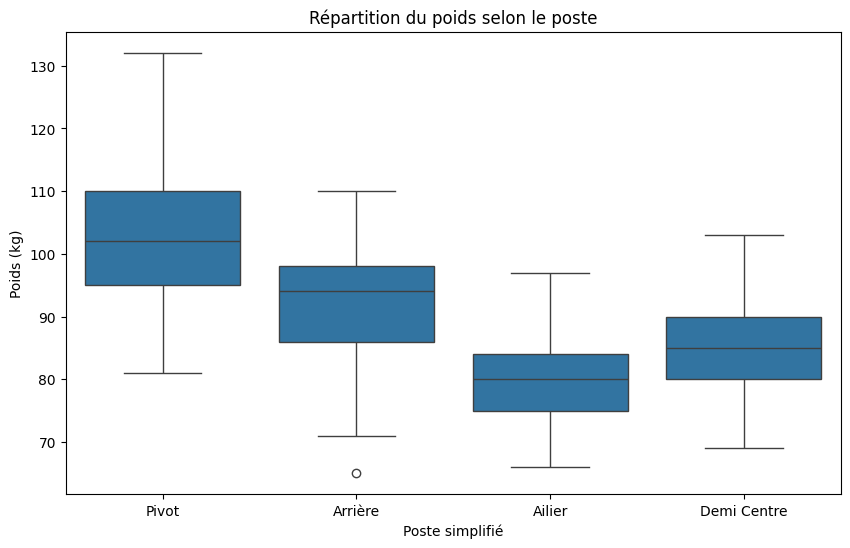

c:\Users\Léo\Desktop\GIT_HANDBALL\Handball_Position_Predicting\Stat_desc.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Poste simplifié", y=y, data=data, palette=palette)


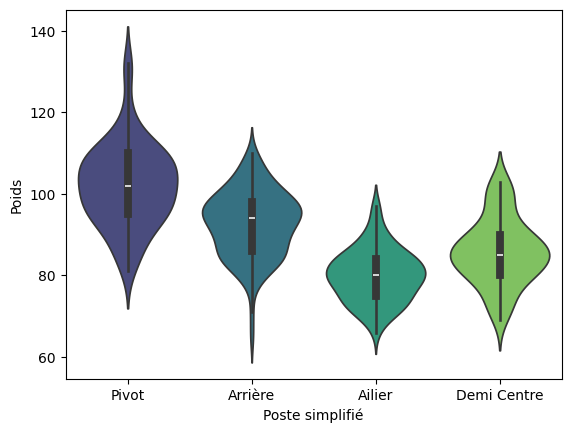

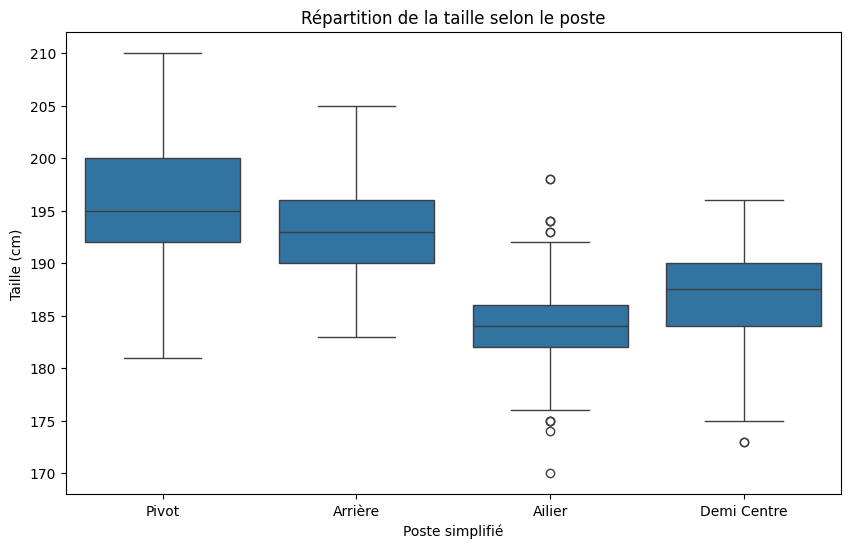

c:\Users\Léo\Desktop\GIT_HANDBALL\Handball_Position_Predicting\Stat_desc.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Poste simplifié", y=y, data=data, palette=palette)


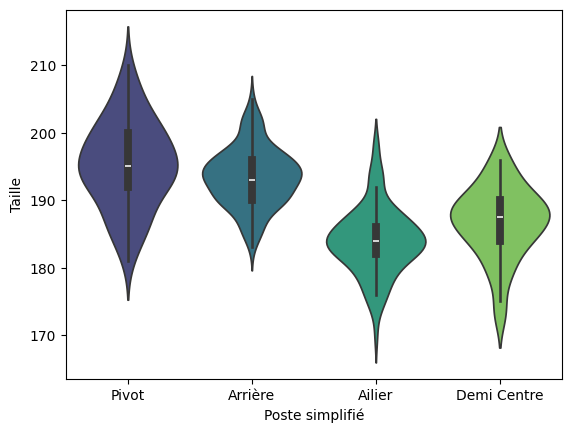

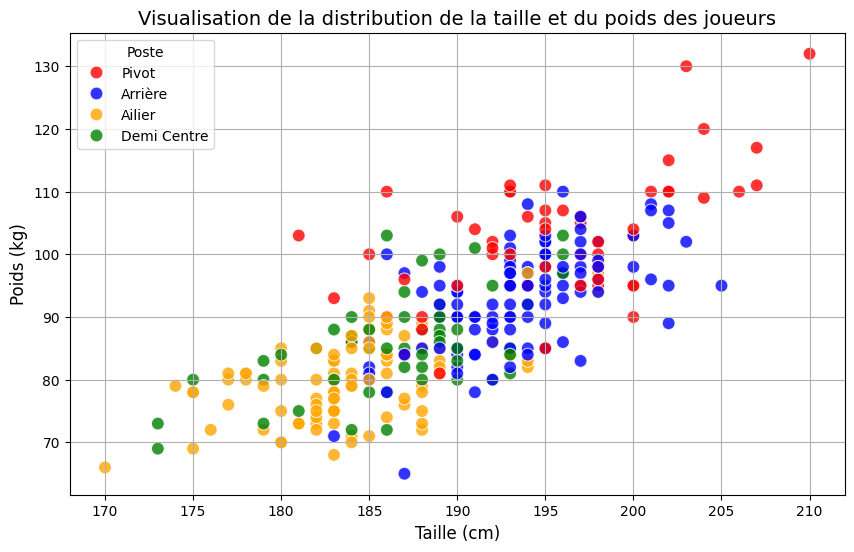

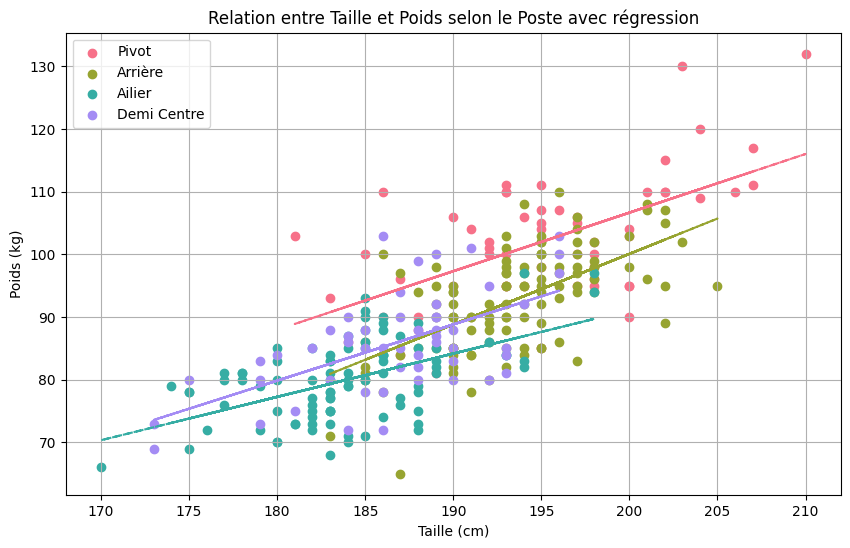

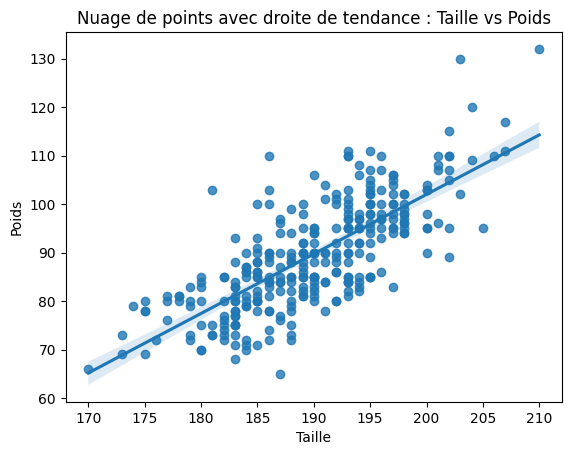

In [6]:
## Statistiques descriptives des données morphologiques

# à modifier pour ne garder que les graphiques qu'on juge pertinent

from Stat_desc import *

# Boite à moustache du poids selon le poste
Boxplot_poids(DF_joueur_rapport_nettoye)
afficher_violinplot(DF_joueur_rapport_nettoye,y='Poids')

# Boite à moustache de la taille selon le poste
Boxplot_taille(DF_joueur_rapport_nettoye)
afficher_violinplot(DF_joueur_rapport_nettoye,y='Taille')


# Représentation des joueurs sur le plan Taille, Poids
Visualisation_Taille_Poids(DF_joueur_rapport_nettoye)
# Avec Regression
afficher_regression_par_poste(DF_joueur_rapport_nettoye)

# Nuage de points avec toutes les infos
scatter_plot(DF_joueur_rapport_nettoye,"Taille","Poids", ["Nom", "Âge", "IMC"])

# Nuage et droite de regression de y sur x
nuage_droite(DF_joueur_rapport_nettoye, x='Taille',y='Poids')


BlaBla sur le choix des modèles, de la façon dont on veut classifier, etc...

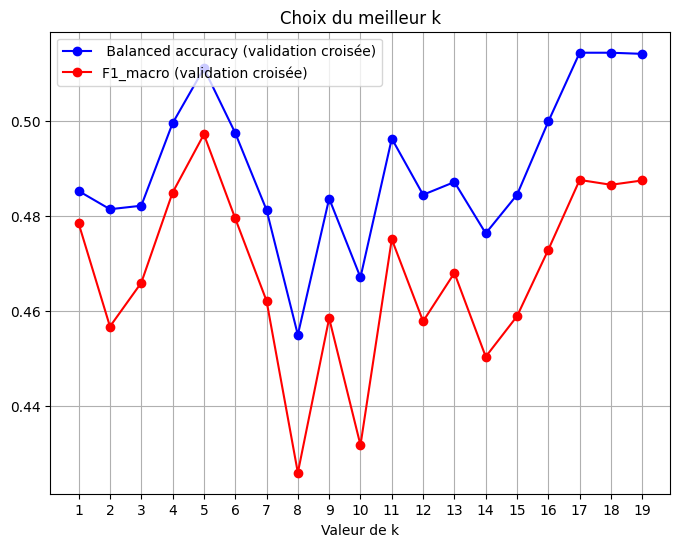

In [7]:
## Choix des paramètres pour les modèles

from Choix_modele import *

parametre_KNN(DF_joueur_rapport_nettoye)

In [8]:
print('Meilleurs paramètres pour SVM :')
parametres_SVM(DF_joueur_rapport_nettoye,metrique='f1_macro')

Meilleurs paramètres pour SVM :
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .................................C=0.1, gamma=scale; total time=   0.0s
[CV] END .................................C=0.1, gamma=scale; total time=   0.0s
[CV] END .................................C=0.1, gamma=scale; total time=   0.0s
[CV] END .................................C=0.1, gamma=scale; total time=   0.0s
[CV] END .................................C=0.1, gamma=scale; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ......

{'C': 100, 'gamma': 0.01}

In [9]:
print('Meilleurs paramètres pour Random Forest :')
parametres_Random_Forest(DF_joueur_rapport_nettoye,metrique='f1_macro')

Meilleurs paramètres pour Random Forest :
Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

BlaBla sur l'évaluation des modèles (parler de la métrique d'évaluation entre autres)

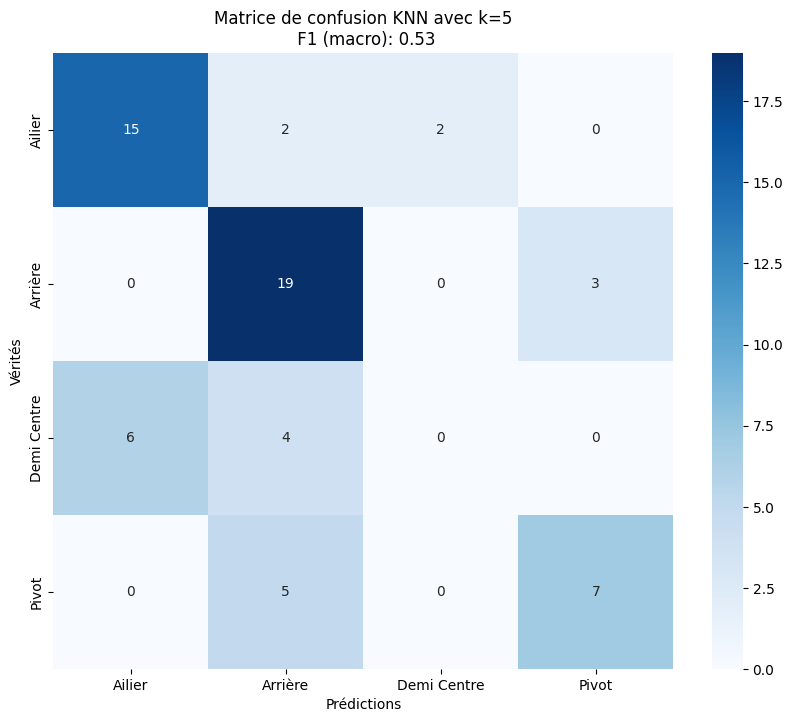

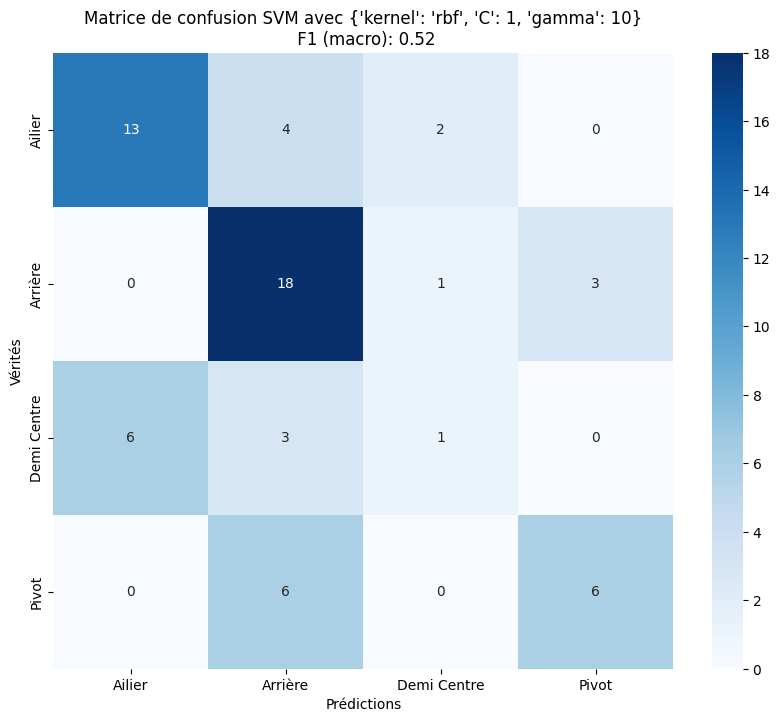

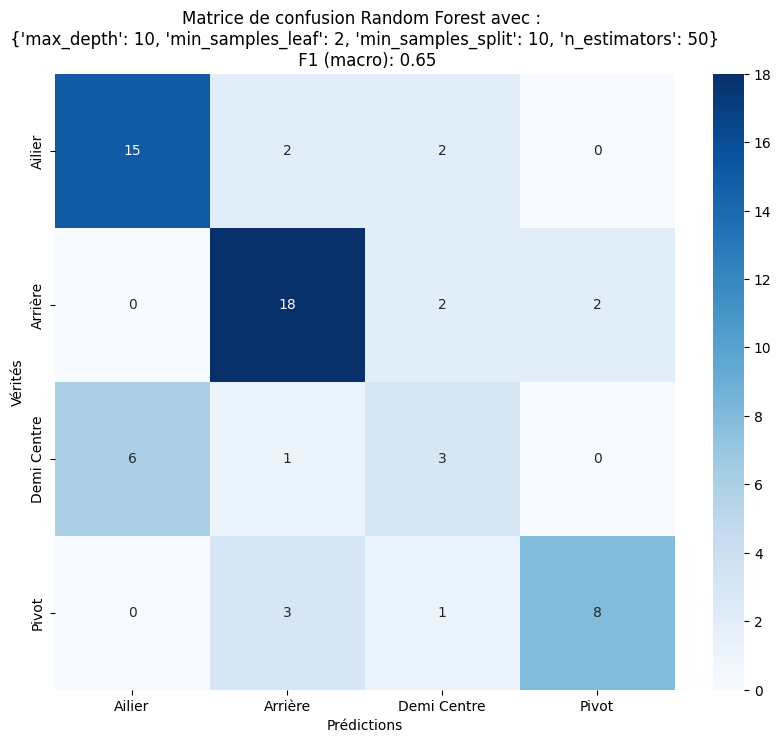

In [10]:
## Evaluation des performances des différents modèles

from Evaluation import *

# Modèle KNN :
best_k = 5
Eval_modele_KNN(DF_joueur_rapport_nettoye,best_k)

# Modèle SVM :
best_parametres_SVM = {'kernel': 'rbf','C': 1, 'gamma': 10}
Eval_modele_SVM(DF_joueur_rapport_nettoye,best_parametres_SVM)

# Modèle Random Forest :
best_parametres_RF = {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Eval_modele_Random_Forest(DF_joueur_rapport_nettoye,best_parametres_RF)

BlaBla sur le modèle choisi et pourquoi,
Prédiction sur l'ensemble de nos données

In [11]:
## Prédiction sur l'ensemble du DataSet

from Prediction import *


Prediction(DF_joueur_rapport_nettoye,type_modele='SVC',telechargement='DF_joueur_rapport_predit.csv')

DF_joueur_rapport_predit = pd.read_csv("DF_joueur_rapport_predit.csv",index_col=0)

DF_joueur_rapport_predit.head(10)

,Poste,Nationalité,Date de naissance,Âge,Taille,Poids,Club actuel,Dernière saison,Poste simplifié,IMC,Poste prédit
Kamil Syprzak,Pivot,Pologne,27/07/1991,33.0,207.0,117.0,Paris,NaN,Pivot,27.305188,Pivot
Tom Pelayo,Arrière Droit,France,23/02/1997,27.0,189.0,95.0,Dunkerque,NaN,Arrière,26.595000,Arrière
Gabriel Loesch,Ailier Droit,France,12/07/1995,29.0,182.0,73.0,Aix,NaN,Ailier,22.038401,Ailier
Chema Marquez,Demi Centre,Espagne,20/12/1996,28.0,187.0,94.0,Saint-Raphaël,NaN,Demi Centre,26.880952,Arrière
Nemanja Ilic,Ailier Gauche,Serbie,11/05/1990,34.0,177.0,76.0,Toulouse,NaN,Ailier,24.258674,Ailier
Benjamin Richert,Ailier Droit,France,18/04/1998,26.0,187.0,76.0,Chambéry,NaN,Ailier,21.733535,Ailier
Valero Rivera,Ailier Gauche,Espagne,22/02/1985,39.0,186.0,83.0,Nantes,NaN,Ailier,23.991213,Ailier
Ian Tarrafeta,Demi Centre,Espagne,04/01/1999,25.0,188.0,88.0,Aix,NaN,Demi Centre,24.898144,Demi Centre
Elohim Prandi,Arrière Gauche,France,24/08/1998,26.0,193.0,101.0,Paris,NaN,Arrière,27.114822,Pivot
Mario Lopez Alvarez,Ailier Droit,Espagne,19/09/1994,30.0,178.0,81.0,Créteil,NaN,Ailier,25.564954,Ailier


BlaBla sur le dataframe des matchs + jointure des 2 dataframes + indicateur de performance

In [21]:
## Nettoyage du DataFrame contenant les données de match

from fusion_csv import *

# Ligne à enlever lorsqu'on lancera le tout
DF_match_rapport = pd.read_csv("Donnees/Donnees_match.csv",index_col=0)

# Nettoyage
traitement(DF_match_rapport,nom_fichier="DF_match_rapport_nettoye.csv")

DF_match_rapport_nettoye = pd.read_csv("DF_match_rapport_nettoye.csv",index_col=0)
# /!\ ajouter la fonction qui crée l'indicateur de performance dans la fonction de traitement

DF_match_rapport_nettoye.head(10)

,Total buts,Total tirs,totalbuts,%total,totalbuts / mj,Buts dans le jeu,Tirs dans le jeu,butstirs,%tirs,tirsbuts / mj,Penalty réussis,Tirs de Penalty,butspenalty,%penalty,penaltybuts / mj,mj,Score LNH *,Temps jeu,Nom formate
SYPRZAK Kamil,220,267,220 / 267,"82,40 %","7,59",131,161,131 / 161,"81,37 %","4,52",89,106,89 / 106,"83,96 %","3,07",29,413.9,08:01:40,Kamil Syprzak
PELAYO Tom,216,294,216 / 294,"73,47 %","7,20",134,190,134 / 190,"70,53 %","4,47",82,104,82 / 104,"78,85 %","2,73",30,470.3,21:16:38,Tom Pelayo
LOESCH Gabriel,191,248,191 / 248,"77,02 %","6,37",107,148,107 / 148,"72,30 %","3,57",84,100,84 / 100,"84,00 %","2,80",30,364.5,27:10:37,Gabriel Loesch
MARQUEZ Chema,189,312,189 / 312,"60,58 %","6,30",178,293,178 / 293,"60,75 %","5,93",11,19,11 / 19,"57,89 %","0,37",30,424.5,17:04:57,Chema Marquez
ILIC Nemanja,183,238,183 / 238,"76,89 %","6,54",116,152,116 / 152,"76,32 %","4,14",67,86,67 / 86,"77,91 %","2,39",28,366.8,21:19:16,Nemanja Ilic
RICHERT Benjamin,170,257,170 / 257,"66,15 %","6,07",84,142,84 / 142,"59,15 %","3,00",86,115,86 / 115,"74,78 %","3,07",28,312.6,15:54:21,Benjamin Richert
RIVERA Valero,169,220,169 / 220,"76,82 %","5,63",89,123,89 / 123,"72,36 %","2,97",80,97,80 / 97,"82,47 %","2,67",30,329.1,18:08:32,Valero Rivera
TARRAFETA Ian,165,246,165 / 246,"67,07 %","6,88",165,246,165 / 246,"67,07 %","6,88",0,0,0 / 0,"0,00 %","0,00",24,443.9,18:39:14,Ian Tarrafeta
PRANDI Elohim,160,248,160 / 248,"64,52 %","5,71",160,248,160 / 248,"64,52 %","5,71",0,0,0 / 0,"0,00 %","0,00",28,373.1,16:34:51,Elohim Prandi
LOPEZ ALVAREZ Mario,159,229,159 / 229,"69,43 %","5,30",95,144,95 / 144,"65,97 %","3,17",64,85,64 / 85,"75,29 %","2,13",30,334.0,21:46:21,Mario Lopez Alvarez


In [24]:
%autoreload 2


In [25]:
# Jointure des 2 DataFrames

from fusion_csv import *

DF_joint_rapport = jointure_df(DF_joueur_rapport_predit,DF_match_rapport_nettoye,telechargement="DF_joint_rapport.csv")

DF_joint_rapport.head(10)

TypeError: 'Index' object is not callable

BlaBla sur la comparaison des performances entre vrai poste et poste prédit

In [ ]:
## Comparaison des performances